<a href="https://colab.research.google.com/github/SJonauskas/Universitetas/blob/main/Architekturos_stiliai_Sarunas_Jonauskas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Šarūnas Jonauskas 2022-04-28

# Projektas: Architektūros stiliaus atpažinimas ir klasifikacija.

Tikslas: Sukurti modelį kuris galėtų atskirti kokiai architektūros rūšiai priklauso matomas pastatas.

Naudojama duomenų bazė – https://www.kaggle.com/datasets/dumitrux/architectural-styles-dataset



Rezultatai lyginami su straipsniu – Architectural Style Classification Using Multinomial Latent Logistic Regression (2014) – https://www.researchgate.net/publication/275604099_Architectural_Style_Classification_Using_Multinomial_Latent_Logistic_Regression

![](https://drive.google.com/uc?export=view&id=10BKFNf1_76vYvl2g9C0JxT82QamfBS5J)

# Planas

1. Įkeliami ir apdorojami duomenys.
2. 10 klasifikacijų (vėliau naudoti 25, jei validavimo rezultatai neblogi). Po 300-500 nuotraukų.
3. 3 architektūros. ResNet, DenseNet, EfficientNet.
4. Keičiant hiperparametrus ieškoma geresnio tinkančio modelio užduočiai. Batch size
5. Testuojama ant savo paties atrinktų nuotraukų.
6. Rezultatų apibendrinimas.

# Bibliotekos ir kitka

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from scipy.io import loadmat
from tensorflow.keras.utils import to_categorical

from numpy.random import seed
seed(1)

from fastai.vision import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
%reload_ext autoreload
%autoreload 2
%matplotlib inline

np.random.seed(100)
tf.random.set_seed(100)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'
reshuffle_each_iteration=False

from tensorflow.keras.models import Model
tf.keras.backend.set_image_data_format('channels_last')

# Duomenų pakrovimas

Iš pradžių reikalinga paruošti duomenus, kad modelis juos priimtu.

![](https://drive.google.com/uc?export=view&id=1iCrecFDazeYLynP-zPeEiTpmj6odPkd3)

In [ ]:
import pathlib
data_dir = pathlib.Path('./drive/MyDrive/Colab Notebooks/Projektas/Nuotraukos_25/')

Treniravimo duomenys. Paliekama 20% validacijai.

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed=123,
    batch_size=96,
    image_size=(224, 224))

Found 10117 files belonging to 25 classes.
Using 8094 files for training.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed=123,
    batch_size=96,
    image_size=(224, 224))

Found 10117 files belonging to 25 classes.
Using 2023 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Achaemenid architecture' 'American Foursquare architecture' 'American craftsman style'
 'Ancient Egyptian architecture' 'Art Deco architecture' 'Art Nouveau architecture' 'Baroque architecture'
 'Bauhaus architecture' 'Beaux-Arts architecture' 'Byzantine architecture' 'Chicago school architecture'
 'Colonial architecture' 'Deconstructivism' 'Edwardian architecture' 'Georgian architecture' 'Gothic architecture'
 'Greek Revival architecture' 'International style' 'Novelty architecture' 'Palladian architecture'
 'Postmodern architecture' 'Queen Anne architecture' 'Romanesque architecture' 'Russian Revival architecture'
 'Tudor Revival architecture']


![](https://drive.google.com/uc?export=view&id=1wvdmOAB_KEexRqrPdPHLeRqkW88IlNy5)

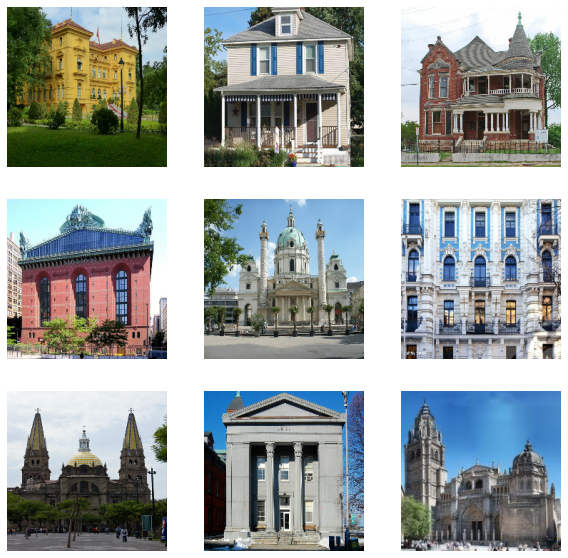

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels(i)])
    plt.axis("off")

# Normalizavimas

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
plt.imshow(first_image), print(labels_batch[0])

# Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomRotation(factor=(-0.5, 0.5)),
    tf.keras.layers.RandomZoom(height_factor=(-0.5, 0.5)),
    tf.keras.layers.RandomContrast(factor=(0.05, 0.5)),
    tf.keras.layers.RandomWidth(factor=(-0.5, 0.5)),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")
  ])

In [ ]:
def scheduler(epoch, lr):
  if epoch < 7:
    return lr
  else:
    return 0.0001

# 1. ResNet

![](https://drive.google.com/uc?export=view&id=1hsiyoZsHi9cnIDMYt7sgzqNKkS7-8vz2)

In [ ]:
from tensorflow.keras.applications import ResNet50V2

inputs = layers.Input(shape=(224, 224, 3))
base_model = ResNet50V2(input_tensor=inputs, include_top=False, input_shape=(224, 224, 3), weights='imagenet')

x = data_augmentation(inputs)
x = base_model.output

# freeze all layers in the base model
base_model.trainable = False

# un-freeze the BatchNorm layers
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True


x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.Dropout(0.5, name="top_dropout")(x)
outputs = layers.Dense(25, activation="softmax", name="predictions", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)


model = Model(inputs, outputs, name='ResNet50V2')

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
                           metrics=["accuracy"])

In [ ]:
#model.summary()

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1, callbacks=[callback])

Epoch 1/10
85/85 [==============================] - 1377s 16s/step - loss: 3.2158 - accuracy: 0.1362 - val_loss: 2.7461 - val_accuracy: 0.2748 - lr: 0.0010
Epoch 2/10
85/85 [==============================] - 153s 2s/step - loss: 2.5220 - accuracy: 0.2984 - val_loss: 2.0408 - val_accuracy: 0.4661 - lr: 0.0010
Epoch 3/10
85/85 [==============================] - 153s 2s/step - loss: 2.1079 - accuracy: 0.4044 - val_loss: 1.8074 - val_accuracy: 0.5121 - lr: 0.0010
Epoch 4/10
85/85 [==============================] - 153s 2s/step - loss: 1.8342 - accuracy: 0.4821 - val_loss: 1.6738 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 5/10
85/85 [==============================] - 153s 2s/step - loss: 1.6567 - accuracy: 0.5318 - val_loss: 1.5983 - val_accuracy: 0.5699 - lr: 0.0010
Epoch 6/10
85/85 [==============================] - 153s 2s/step - loss: 1.5072 - accuracy: 0.5787 - val_loss: 1.5344 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 7/10
85/85 [==============================] - 153s 2s/step - loss: 1

In [ ]:
model.save("./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/ResNet_96/ResNet50V2_tf", save_format='tf')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/ResNet/ResNet50V2_tf/assets


# 2. DenseNet

![](https://drive.google.com/uc?export=view&id=1v9nB6Crq_BwY69Fhquh8KwJtIHv5hjoy)

In [ ]:
from tensorflow.keras.applications import DenseNet121

inputs2 = layers.Input(shape=(224, 224, 3))
base_model2 = DenseNet121(input_tensor=inputs2, include_top=False, input_shape=(224, 224, 3), weights='imagenet')

x = data_augmentation(inputs2)
x = base_model2.output

# freeze all layers in the base model
base_model2.trainable = False

# un-freeze the BatchNorm layers
for layer in base_model2.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.Dropout(0.5, name="top_dropout")(x)
outputs2 = layers.Dense(25, activation="softmax", name="predictions", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)


model2 = Model(inputs2, outputs2, name='DenseNet121')

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
                           metrics=["accuracy"])

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
#model2.summary()

In [ ]:
model2.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1, callbacks=[callback])

Epoch 1/10
127/127 [==============================] - 205s 1s/step - loss: 2.9642 - accuracy: 0.1908 - val_loss: 2.2661 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 2/10
127/127 [==============================] - 181s 1s/step - loss: 1.9871 - accuracy: 0.4476 - val_loss: 1.7365 - val_accuracy: 0.5388 - lr: 0.0010
Epoch 3/10
127/127 [==============================] - 181s 1s/step - loss: 1.5973 - accuracy: 0.5565 - val_loss: 1.7213 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 4/10
127/127 [==============================] - 181s 1s/step - loss: 1.3476 - accuracy: 0.6292 - val_loss: 1.5789 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 5/10
127/127 [==============================] - 180s 1s/step - loss: 1.1924 - accuracy: 0.6787 - val_loss: 1.4000 - val_accuracy: 0.6312 - lr: 0.0010
Epoch 6/10
127/127 [==============================] - 181s 1s/step - loss: 1.0508 - accuracy: 0.7200 - val_loss: 1.4192 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 7/10
127/127 [==============================] - 180s 1s/st

In [ ]:
model2.save("./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/DenseNet/DenseNet121_tf", save_format='tf')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/DenseNet/DenseNet121_tf/assets


# 3. EfficientNet

![](https://drive.google.com/uc?export=view&id=1AHVP05kd9d-UJLwvMs_kX517fHm4hT8O)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

inputs3 = layers.Input(shape=(224, 224, 3))
base_model3 = EfficientNetB0(input_tensor=inputs3, include_top=False, input_shape=(224, 224, 3), weights='imagenet')

x = data_augmentation(inputs3)
x = base_model3.output

# freeze all layers in the base model
base_model3.trainable = False

# un-freeze the BatchNorm layers
for layer in base_model3.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.Dropout(0.5, name="top_dropout")(x)
outputs3 = layers.Dense(25, activation="softmax", name="predictions", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)


model3 = Model(inputs3, outputs3, name='EfficientNetB0')

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
                           metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#model3.summary()

In [ ]:
model3.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1, callbacks=[callback])

Epoch 1/10
127/127 [==============================] - 137s 956ms/step - loss: 3.1993 - accuracy: 0.1348 - val_loss: 2.5043 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 2/10
127/127 [==============================] - 121s 927ms/step - loss: 2.4140 - accuracy: 0.3129 - val_loss: 1.8200 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 3/10
127/127 [==============================] - 120s 924ms/step - loss: 1.9691 - accuracy: 0.4386 - val_loss: 1.5432 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 4/10
127/127 [==============================] - 121s 928ms/step - loss: 1.7181 - accuracy: 0.5091 - val_loss: 1.4200 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 5/10
127/127 [==============================] - 121s 926ms/step - loss: 1.5635 - accuracy: 0.5545 - val_loss: 1.4133 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 6/10
127/127 [==============================] - 121s 928ms/step - loss: 1.4444 - accuracy: 0.5934 - val_loss: 1.3516 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 7/10
127/127 [==========================

In [ ]:
model3.save("./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/EfficientNet/EfficientNetB0_tf", save_format='tf')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/EfficientNet/EfficientNetB0_tf/assets


# 1. 10 kategorijų

|Modelis|Batch Size|Learning rate| Train Acc | Val Acc |
|-|-|-|-|-|
|ResNet|64|0.001|92.03|81.97|
|DenseNet|64|0.001|97.69|85.84|
|EffiecientNet|64|0.001|89.02|85.39|

# 2. 25 kategorijos

|Modelis|Batch Size|Learning rate| Train Acc | Val Acc |
|-|-|-|-|-|
|ResNet|64|0.001|70.74|60.80|
|ResNet|96|0.001|68.96|61.25|
|DenseNet|64|0.001|84.38|68.26|
|EffiecientNet|64|0.001|66.25|64.85|
|EffiecientNet|96|0.001|64.85|64.71|

# Testavimas

Duomenų pakrovimas

In [ ]:
data_dir_test = pathlib.Path('./drive/MyDrive/Colab Notebooks/Projektas/Testas_Gothic/')

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory=data_dir_test,
    labels='inferred',
    label_mode='categorical',
    color_mode="rgb",
    seed=123,
    batch_size=64,
    image_size=(224, 224))

Found 15 files belonging to 1 classes.


In [ ]:
normalization_layer2 = tf.keras.layers.Rescaling(1./255)

normalized_ds2 = test_ds.map(lambda x, y: (normalization_layer2(x), y))
image_batch2, labels_batch2 = next(iter(normalized_ds2))
first_image2 = image_batch2[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image2), np.max(first_image2))

0.009543641 1.0


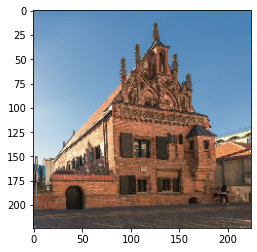

In [ ]:
plt.imshow(first_image2)

# I. Testas ant ResNet

In [ ]:
Testas = model.predict(test_ds)

In [ ]:
Prediction = tf.math.argmax(Testas, axis=1)
category_prediction = tf.cast(Prediction, tf.int32)
Result = Prediction.numpy()

In [ ]:
Result

array([15, 24,  8, 15, 15, 24, 21, 23, 21, 15, 22, 15, 15, 14,  4])

# II. Testas ant DenseNet

In [ ]:
Testas2 = model2.predict(test_ds)

In [ ]:
Prediction2 = tf.math.argmax(Testas2, axis=1)
category_prediction2 = tf.cast(Prediction2, tf.int32)
Result2 = Prediction2.numpy()

In [ ]:
Result2

array([23, 23,  9, 15, 24, 15, 22, 11,  9, 15, 15, 23, 22,  6,  6])

# III. Testas and EfficientNet

In [ ]:
Testas3 = model3.predict(test_ds)

In [ ]:
Prediction3 = tf.math.argmax(Testas3, axis=1)
category_prediction3 = tf.cast(Prediction3, tf.int32)
Result3 = Prediction3.numpy()

In [ ]:
Result3

array([23, 22, 11, 15, 15, 24, 15,  6, 24, 11, 15, 24, 15, 15, 18])

# Testavimo rezultatai

Gothic architecture (10 kategorijų) (40 %)

|Model|Accuracy|
|-|-|
|ResNet|6/15|
|DenseNet|6/15|
|EfficientNet|7/15|

Gothic architecture (25 kategorijos) (40 %)

|Model|Batch size|Accuracy|
|-|-|-|
|ResNet|64|6/15|
|ResNet|96|6/15|
|DenseNet|64|4/15|
|EfficientNet|64|6/15|
|EfficientNet|96|6/15|

International style? (25 kategorijos)

Maišoma su Postmodern ar Deconstructivism, nes labai panašios architektūros. Sujungus 60-80%

|Model|Batch size|Accuracy|Postmodern|International + Postmodern|
|-|-|-|-|-|
|ResNet|64|5/15|5/15|10/15|
|ResNet|96|5/15|7/15|12/15|
|DenseNet|64|2/15|6/15|8/15|
|EfficientNet|64|1/15|9/15|10/15|
|EfficientNet|96|7/15|3/15|10/15|

Russian Revival architecture (25 kategorijos) (60-80%)

|Model|Batch size|Accuracy|
|-|-|-|
|ResNet|64|10/15|
|ResNet|96|9/15|
|DenseNet|64|10/15|
|EfficientNet|64|10/15|
|EfficientNet|96|12/15|


# Sukurto modelio pakrovimas

# ResNet

In [ ]:
ResNetModel = tf.keras.models.load_model("./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/ResNet_96/ResNet50V2_tf")

In [ ]:
Testas_load = ResNetModel.predict(test_ds)

Prediction_load = tf.math.argmax((Testas_load), axis=1)
category_prediction_load = tf.cast(Prediction_load, tf.int32)
Result_load = Prediction_load.numpy()

Result_load

array([ 6, 12, 15, 22, 21, 15,  5, 15,  5, 23, 21, 15, 15, 18, 15])

In [ ]:
Testas_load[0].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.02, 0.08, 0.46, 0.  , 0.07, 0.01, 0.  , 0.11, 0.  , 0.06, 0.01, 0.01, 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.06, 0.01, 0.07, 0.01], dtype=float32)

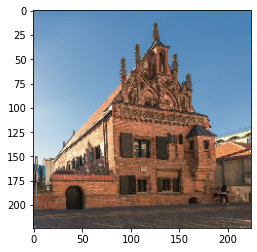

In [ ]:
plt.imshow(image_batch2[0])

In [ ]:
Testas_load[2].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ], dtype=float32)

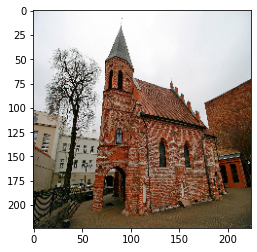

In [ ]:
plt.imshow(image_batch2[2])

# DenseNet

In [ ]:
DenseNetModel = tf.keras.models.load_model("./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/DenseNet/DenseNet121_tf")

In [ ]:
Testas_load = DenseNetModel.predict(test_ds)

Prediction_load = tf.math.argmax((Testas_load), axis=1)
category_prediction_load = tf.cast(Prediction_load, tf.int32)
Result_load = Prediction_load.numpy()

Result_load

array([23, 23,  9, 15, 24, 15, 22, 11,  9, 15, 15, 23, 22,  6,  6])

# EfficientNet

In [ ]:
EfficientNetModel = tf.keras.models.load_model("./drive/MyDrive/Colab Notebooks/Projektas/Modelis_25/EfficientNet_96/EfficientNetB0_tf")

In [ ]:
Testas_load = EfficientNetModel.predict(test_ds)

Prediction_load = tf.math.argmax((Testas_load), axis=1)
category_prediction_load = tf.cast(Prediction_load, tf.int32)
Result_load = Prediction_load.numpy()

Result_load

array([ 5, 22, 22, 15, 15, 22, 15,  6, 11, 11, 15, 24, 15, 15, 18])

# Fizikos fakultetas

In [ ]:
data_dir_ff = pathlib.Path('./drive/MyDrive/Colab Notebooks/Projektas/FF/')

In [ ]:
test_ds_ff = keras.utils.image_dataset_from_directory(
    directory=data_dir_ff,
    labels='inferred',
    label_mode='categorical',
    color_mode="rgb",
    seed=123,
    batch_size=64,
    image_size=(224, 224))

Found 1 files belonging to 1 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = test_ds_ff.map(lambda x, y: (normalization_layer2(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.024829606 1.0


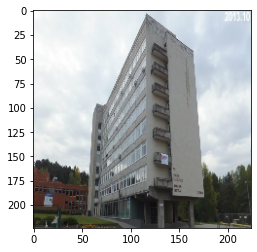

In [ ]:
plt.imshow(first_image)

In [ ]:
Testas_load = EfficientNetModel.predict(test_ds_ff)

In [ ]:
Testas_load[0].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.63, 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.24,
       0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  ], dtype=float32)

Bauhaus - 0.63

International - 0.24

Postmodern - 0.05

Art Deco - 0.05

Deconstructivism - 0.02

Chicago school - 0.01


In [ ]:
data_dir_giga = pathlib.Path('./drive/MyDrive/Colab Notebooks/Projektas/Giga/')

In [ ]:
test_ds_giga = keras.utils.image_dataset_from_directory(
    directory=data_dir_giga,
    labels='inferred',
    label_mode='categorical',
    color_mode="rgb",
    seed=123,
    batch_size=64,
    image_size=(224, 224))

Found 1 files belonging to 1 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = test_ds_giga.map(lambda x, y: (normalization_layer2(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0001816357 0.8437691


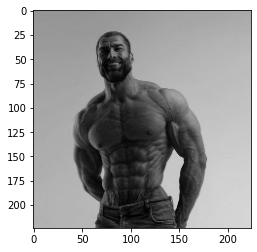

In [ ]:
plt.imshow(first_image)

In [ ]:
Testas_load = EfficientNetModel.predict(test_ds_giga)

In [ ]:
Testas_load[0].round(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Novelty - 1.0